The goal of this file is to run the following estimation experiments
* Output prediction accuracy as a function of ROM dimension (open- and closed-loop prediction)
* Full-order state prediction accuracy as a function of ROM dimension (open- and closed-loop prediction)

This notebook will also generate the following figures: 
* For a ROM dimension where all ROMs are decently predictive
    1. Output estimation trajectories for open and closed loop estimators on trajectories from the training and test set
    2. avg and std estimation error at that dimension
* Output estimation errors as a function of ROM dimension (subplot for open loop and for closed loop)


In [312]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
 
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
from scipy.signal import cont2discrete
import pyvista as pv
import h5py
import mat73
import dask.array as da
from dask.distributed import Client, LocalCluster
config = dotenv_values("../.env")


In [313]:
####### Set up dask cluster #######
# Setup Dask client
# cluster = LocalCluster() # Launches a scheduler and workers locally
# client = Client(cluster) # Connect to distributed cluster and override default
client = Client('tcp://127.0.0.1:8786')
client.cluster

####### # Set up hyperparameters for all ROMs  #######
n_timesteps = 1000 # Number of timesteps to pull from each episode
dt = 0.01

ns_ROM = np.arange(2,22,2) # Dimensions of ROM state space
ns_ROM_lopinf = np.arange(4,22,4) # Dimensions of ROM state space for LOpInf

# Training Trials 
train_trials = [16, 39]#[0,1,3,4,5,6,7,8,11,12,13,14,15,16,18,19,20,22,23,24,26,27,28,29,30,31,32,33,35,36,37,39]#[39] #
n_train = len(train_trials) # Number of training trials

# Testing Trials
test_trials = [2,9,10,17,21,25,34,38]
n_test = len(test_trials) # Number of testing trials

In [314]:
####### Set up filepaths #######
# Setup filepaths for reading data 
filepath = config["currentDirectory"] + "data/archivedDataSets/ContiguousAssembly/"
romDir = config["currentDirectory"] + "data/archivedDataSets/ContiguousAssembly/ROMs/"

In [315]:
####### Load in data ####### 
# Read in full data set 
data = h5py.File(filepath+ "FreqSweepDataset.hdf5", 'r')
X_fom = da.from_array(data["stateData"], chunks=(4096, 4096,1))
U_fom = da.from_array(data["inputData"], chunks=(4096, 4096,1))
U_fom = U_fom[:,0:n_timesteps,:].compute()
Y_fom = da.from_array(data["outputData"], chunks=(4096, 4096,1))
x0 = data["stateData"][:,0,0]
y0 = data["outputData"][:,0,0]
Y_fom = Y_fom[:,0:n_timesteps,:] - y0[:,None,None]
Y_fom = Y_fom.compute()


n = X_fom.shape[0]
l = U_fom.shape[0]
m = Y_fom.shape[0]


In [316]:
# Initialize arrays for storing relative estimation errors 
num_ROMs = len(ns_ROM)
num_ROMs_lopinf = len(ns_ROM_lopinf)
rel_errors_era_ol = np.zeros((num_ROMs, n_test))
rel_errors_dmdc_ol = np.zeros((num_ROMs, n_test))
rel_errors_lopinf_ol = np.zeros((num_ROMs_lopinf, n_test))

In [317]:
# iterate over all ROM dimensions for ERA and DMDc
for i_romDim in range(num_ROMs):
    print("Running open loop simulation for ROM dimension: " + str(ns_ROM[i_romDim]))
    # Load in ROM models
    era_file = romDir + "eraSystemMatrices_" + str(ns_ROM[i_romDim])+"dim_" +str(n_train)+"train" +".npz"
    dmd_file = romDir + "dmdcSystemMatrices_" + str(ns_ROM[i_romDim])+"dim_" +str(n_train)+"train" + ".npz"
    eraData = np.load(era_file)
    dmdcData = np.load(dmd_file)
    A_era = eraData["A_era"]
    B_era = eraData["B_era"]
    C_era = eraData["C_era"]
    D_era = eraData["D_era"]
    x0_era = eraData["x0"]
    y0_era = eraData["y0"]
    A_dmdc = dmdcData["A_dmdc"]
    B_dmdc = dmdcData["B_dmdc"]
    C_dmdc = dmdcData["C_dmdc"]
    x0_dmdc = dmdcData["x0"]
    y0_dmdc = dmdcData["y0"]
    basis_dmdc = dmdcData["basis_dmdc"]
    # Initialize array for holding output estimates over time
    Y_era_ol = np.zeros((m, n_timesteps, n_test))
    Y_dmdc_ol = np.zeros((m, n_timesteps, n_test))
    # Initialize arrays for holding state estimates
    X_era_ol = np.zeros((ns_ROM[i_romDim], n_timesteps, n_test))
    X_dmdc_ol = np.zeros((ns_ROM[i_romDim], n_timesteps, n_test))
    # Iterate over all trials, running open loop simulations
    for k in range(n_test):
        Y_era_ol[:,0,k] = C_era @ X_era_ol[:,0,k] + D_era @ U_fom[:,0,test_trials[k]] # grab input data from kth test trial
        # Iterate over timesteps
        for i in range(n_timesteps-1):
            # Compute open loop state estimate
            X_era_ol[:,i+1,k] = A_era @ X_era_ol[:,i,k] + B_era @ U_fom[:,i,test_trials[k]] # grab input data from kth test trial
            X_dmdc_ol[:,i+1,k] = A_dmdc @ X_dmdc_ol[:,i,k] + B_dmdc @ U_fom[:,i,test_trials[k]]

            # Compute open loop output estimate
            Y_era_ol[:,i+1,k] = C_era @ X_era_ol[:,i+1,k] + D_era @ U_fom[:,i+1,test_trials[k]]
            Y_dmdc_ol[:,i+1,k] = C_dmdc @ X_dmdc_ol[:,i+1,k] 
    # print("Computing relative errors...")
    for i in range(n_test):
        # print("Test trial: " + str(i))
        rel_errors_era_ol[i_romDim,i] = np.linalg.norm(Y_fom[:,:,test_trials[i]]-Y_era_ol[:,:,i],)/np.linalg.norm(Y_fom[:,:,test_trials[i]])
        rel_errors_dmdc_ol[i_romDim,i] = np.linalg.norm(Y_fom[:,:,test_trials[i]]-Y_dmdc_ol[:,:,i])/np.linalg.norm(Y_fom[:,:,test_trials[i]])
            
        

Running open loop simulation for ROM dimension: 2
Running open loop simulation for ROM dimension: 4
Running open loop simulation for ROM dimension: 6
Running open loop simulation for ROM dimension: 8
Running open loop simulation for ROM dimension: 10
Running open loop simulation for ROM dimension: 12
Running open loop simulation for ROM dimension: 14
Running open loop simulation for ROM dimension: 16
Running open loop simulation for ROM dimension: 18
Running open loop simulation for ROM dimension: 20


In [318]:
# iterate over all ROM dimensions for LOpInf
for i_romDim in range(len(ns_ROM_lopinf)):
    print("Running open loop simulation for ROM dimension: " + str(ns_ROM_lopinf[i_romDim]))
    # Load in ROM models
    lopinf_file = romDir + "lopinfSystemMatrices_" + str(ns_ROM_lopinf[i_romDim])+"dim_" +"1train" +".npz"
    lopinfData = np.load(lopinf_file)
    A_lopinf = lopinfData["A_lopinf"]
    B_lopinf = lopinfData["B_lopinf"]
    C_lopinf = lopinfData["C_lopinf"]
    D_lopinf = lopinfData["D_lopinf"]
    x0_lopinf = lopinfData["x0"]
    y0_lopinf = lopinfData["y0"]
    # Initialize array for holding output estimates over time
    Y_lopinf_ol = np.zeros((m, n_timesteps, n_test))
    # Initialize arrays for holding state estimates
    X_lopinf_ol = np.zeros((ns_ROM_lopinf[i_romDim], n_timesteps, n_test))
    # Iterate over all trials, running open loop simulations
    for k in range(n_test):
        Y_lopinf_ol[:,0,k] = C_lopinf @ X_lopinf_ol[:,0,k] + D_lopinf @ U_fom[:,0,test_trials[k]] # grab input data from kth test trial
        # Iterate over timesteps
        for i in range(n_timesteps-1):
            # Compute open loop state estimate
            X_lopinf_ol[:,i+1,k] = A_lopinf @ X_lopinf_ol[:,i,k] + B_lopinf @ U_fom[:,i,test_trials[k]] # grab input data from kth test trial
            # Compute open loop output estimate
            Y_lopinf_ol[:,i+1,k] = C_lopinf @ X_lopinf_ol[:,i+1,k] + D_lopinf @ U_fom[:,i+1,test_trials[k]]
    # print("Computing relative errors...")
    for i in range(n_test):
        # print("Test trial: " + str(i))
        rel_errors_lopinf_ol[i_romDim,i] = np.linalg.norm(Y_fom[:,:,test_trials[i]]-Y_lopinf_ol[:,:,i])/np.linalg.norm(Y_fom[:,:,test_trials[i]])        



Running open loop simulation for ROM dimension: 4
Running open loop simulation for ROM dimension: 8
Running open loop simulation for ROM dimension: 12
Running open loop simulation for ROM dimension: 16
Running open loop simulation for ROM dimension: 20


In [319]:
# Compute average and standard deviation of relative errors
avg_rel_errors_era_ol = np.mean(rel_errors_era_ol, axis=1)
std_rel_errors_era_ol = np.std(rel_errors_era_ol, axis=1)
avg_rel_errors_dmdc_ol = np.mean(rel_errors_dmdc_ol, axis=1)
std_rel_errors_dmdc_ol = np.std(rel_errors_dmdc_ol, axis=1)
avg_rel_errors_lopinf_ol = np.mean(rel_errors_lopinf_ol, axis=1)
std_rel_errors_lopinf_ol = np.std(rel_errors_lopinf_ol, axis=1)


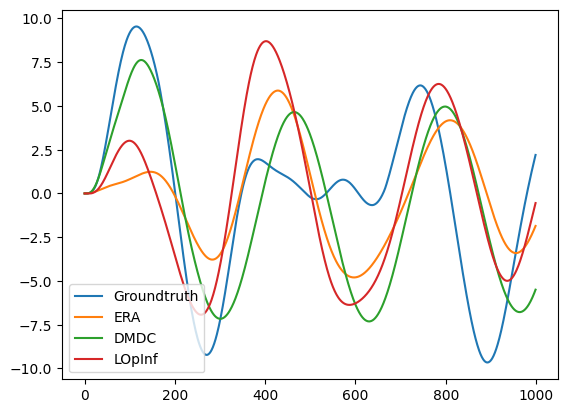

In [320]:
# Plot first output for each method on the first trial
steps = 1000
episode = 4
output = 39
plt.figure()
plt.plot(Y_fom[output,:steps,test_trials[episode]], label="Groundtruth")
plt.plot(Y_era_ol[output,:steps,episode], label="ERA")
plt.plot(Y_dmdc_ol[output,:steps,episode], label="DMDC")
plt.plot(Y_lopinf_ol[output,:steps,episode], label="LOpInf")
plt.legend()
plt.show()


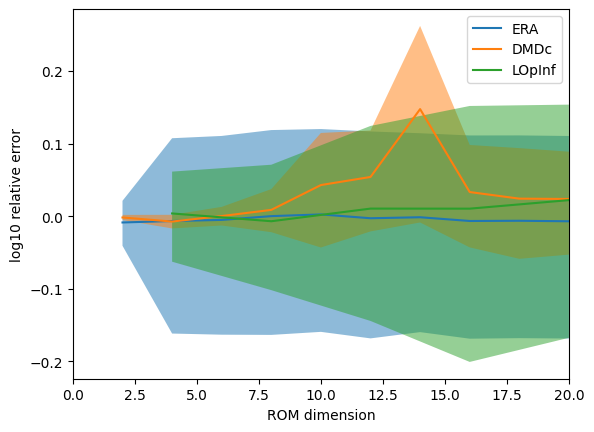

In [323]:
# Plot log of relative erros for each method over ROM dimension with grey regions indicating standard deviation
plt.figure()
plt.plot(ns_ROM, np.log10(avg_rel_errors_era_ol), label="ERA")
plt.fill_between(ns_ROM, np.log10(avg_rel_errors_era_ol-std_rel_errors_era_ol), np.log10(avg_rel_errors_era_ol+std_rel_errors_era_ol), alpha=0.5)
plt.plot(ns_ROM, np.log10(avg_rel_errors_dmdc_ol), label="DMDc")
plt.fill_between(ns_ROM, np.log10(avg_rel_errors_dmdc_ol-std_rel_errors_dmdc_ol), np.log10(avg_rel_errors_dmdc_ol+std_rel_errors_dmdc_ol), alpha=0.5)
plt.plot(ns_ROM_lopinf, np.log10(avg_rel_errors_lopinf_ol), label="LOpInf")
plt.fill_between(ns_ROM_lopinf, np.log10(avg_rel_errors_lopinf_ol-std_rel_errors_lopinf_ol), np.log10(avg_rel_errors_lopinf_ol+std_rel_errors_lopinf_ol), alpha=0.5)
# Show only the first 50 dimensions
plt.xlim(0,20)
# Refit y-axis
plt.xlabel("ROM dimension")
plt.ylabel("log10 relative error")
plt.legend()
plt.show()


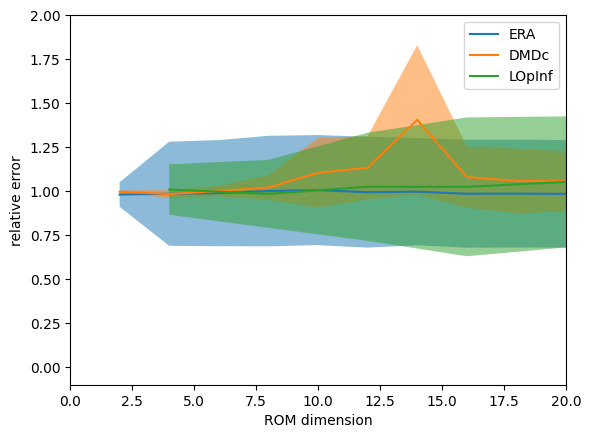

In [322]:
# Plot relative erros for each method over ROM dimension with grey regions indicating standard deviation
plt.figure()
plt.plot(ns_ROM, avg_rel_errors_era_ol, label="ERA")
plt.fill_between(ns_ROM, avg_rel_errors_era_ol-std_rel_errors_era_ol, avg_rel_errors_era_ol+std_rel_errors_era_ol, alpha=0.5)
plt.plot(ns_ROM, avg_rel_errors_dmdc_ol, label="DMDc")
plt.fill_between(ns_ROM, avg_rel_errors_dmdc_ol-std_rel_errors_dmdc_ol, avg_rel_errors_dmdc_ol+std_rel_errors_dmdc_ol, alpha=0.5)
plt.plot(ns_ROM_lopinf, avg_rel_errors_lopinf_ol, label="LOpInf")
plt.fill_between(ns_ROM_lopinf, avg_rel_errors_lopinf_ol-std_rel_errors_lopinf_ol, avg_rel_errors_lopinf_ol+std_rel_errors_lopinf_ol, alpha=0.5)
# Show only the first 50 dimensions
plt.xlim(0,20)
# Refit y-axis
plt.ylim(-0.1,2)
plt.xlabel("ROM dimension")
plt.ylabel("relative error")
plt.legend()
plt.show()